In [1]:
import warnings
warnings.filterwarnings("ignore")
import sys, os
sys.path.append(os.path.abspath("../.."))
from configs import GOOGLE_APPLICATION_CREDENTIALS,GCS_BUCKET_NAME,GCS_PROJECT_ID
from google.cloud import bigquery
from src.utils.io_utils import upload_to_bigquery
from clean_utils import *

In [2]:
client = bigquery.Client.from_service_account_json(GOOGLE_APPLICATION_CREDENTIALS)
table_id = f"{GCS_PROJECT_ID}.{GCS_BUCKET_NAME}.data_train_model"
table_id_done = f"{GCS_PROJECT_ID}.{GCS_BUCKET_NAME}.data_done"

In [3]:
query = """SELECT *
FROM `khangtestdbt.xecupredict.data_cleaned` """
data_cleaned = client.query(query).to_dataframe()
data_cleaned.head(1)

,km,origin,body,fuel,name,price,brand,age
0,70000.0,Trong nước,suv,Khác,Hyundai Santa Fe 2021,780000000.0,Hyundai,4


In [4]:
df = data_cleaned.copy()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5640 entries, 0 to 5639
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   km      5640 non-null   float64
 1   origin  5640 non-null   object 
 2   body    5640 non-null   object 
 3   fuel    5640 non-null   object 
 4   name    5640 non-null   object 
 5   price   5640 non-null   float64
 6   brand   5640 non-null   object 
 7   age     5640 non-null   Int64  
dtypes: Int64(1), float64(2), object(5)
memory usage: 358.1+ KB


In [6]:
df.duplicated().sum()

np.int64(97)

In [7]:
df.drop_duplicates(inplace=True)

1.km

In [8]:
df.km.describe()

count      5543.000000
mean      63706.379397
std       37745.345836
min         105.000000
25%       35000.000000
50%       60000.000000
75%       90000.000000
max      182000.000000
Name: km, dtype: float64

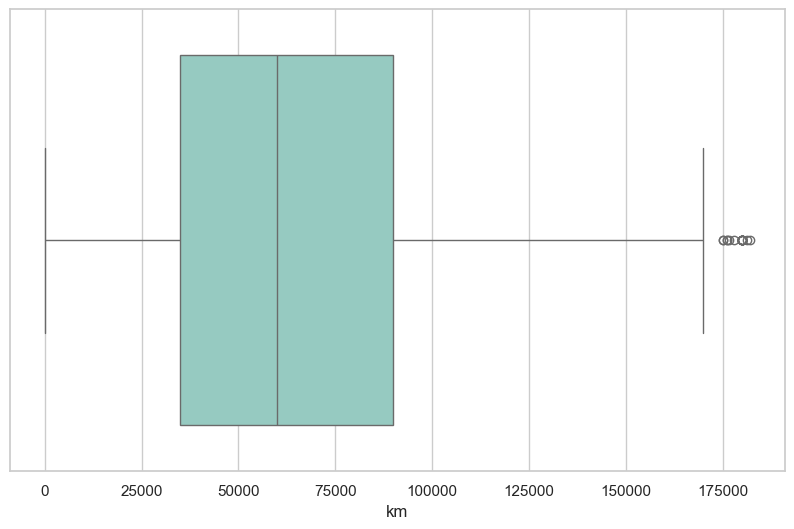

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid") 

plt.figure(figsize=(10,6))
ax = sns.boxplot(
    x="km",
    data=df,
    palette="Set3"  
)
plt.show()


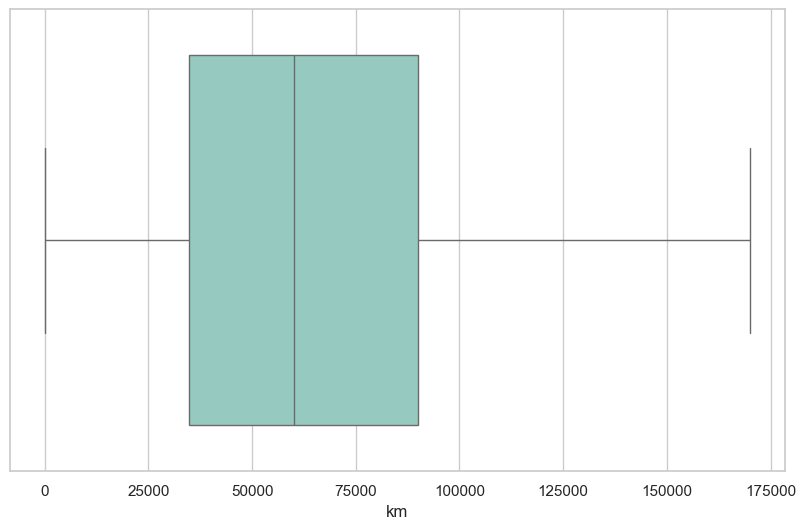

In [10]:
df = remove_outliers_iqr(df, 'km')

plt.figure(figsize=(10,6))
ax = sns.boxplot(
    x="km",
    data=df,
    palette="Set3"  
)
plt.show()

2.origin

In [11]:
df.origin.value_counts()

origin
Nhập khẩu     1845
Trong nước    1700
trong nước    1137
nhập khẩu      842
Name: count, dtype: int64

In [12]:
df["origin"] = df["origin"].str.strip().str.lower()

df["origin"] = df["origin"].replace({
    "nhập khẩu": "Nhập khẩu",
    "trong nước": "Trong nước"
})

df["origin"].value_counts()


origin
Trong nước    2837
Nhập khẩu     2687
Name: count, dtype: int64

3.body

In [13]:
df["body"].value_counts()

body
sedan                    1508
suv                      1396
suv / cross over          760
hatchback                 437
kiểu dáng khác            269
crossover                 234
minivan (mpv)             231
pick-up (bán tải)         149
mpv                       132
van/minivan               127
bán tải / pickup         83
bán tải                    83
van                        53
convertible/cabriolet      18
coupe                      15
xe tải                      8
sport car                   7
convertible                 5
coupe (2 cửa)               3
mui trần                    3
truck                       2
wagon                       1
Name: count, dtype: int64

In [14]:
def normalize_body(x):
    x = str(x).lower().strip()
    if x in ["suv", "suv / cross over", "crossover"]:
        return "SUV"
    elif x in ["sedan"]:
        return "Sedan"
    elif x in ["hatchback"]:
        return "Hatchback"
    elif x in ["minivan (mpv)", "mpv", "van/minivan"]:
        return "MPV"
    elif x in ["pick-up (bán tải)", "bán tải / pickup", "bán tải"]:
        return "Pickup"
    elif x in ["convertible/cabriolet", "convertible", "mui trần"]:
        return "Convertible"
    elif x in ["coupe", "coupe (2 cửa)"]:
        return "Coupe"
    elif x in ["wagon"]:
        return "Wagon"
    elif x in ["sport car"]:
        return "Sports Car"
    elif x in ["xe tải", "truck"]:
        return "Truck"
    else:
        return "Other"

df["body"] = df["body"].apply(normalize_body)

df["body"].value_counts()


body
SUV            2390
Sedan          1508
MPV             490
Hatchback       437
Other           322
Pickup          315
Convertible      26
Coupe            18
Truck            10
Sports Car        7
Wagon             1
Name: count, dtype: int64

4.fuel

In [15]:
df["fuel"].value_counts()

fuel
Xăng      3277
Khác      1200
Dầu        695
Điện       235
Hybrid     117
Name: count, dtype: int64

5.price

In [16]:
df["price"].describe()

count    5.524000e+03
mean     6.985994e+08
std      5.477634e+08
min      5.000000e+06
25%      3.800000e+08
50%      5.580000e+08
75%      8.190000e+08
max      3.399000e+09
Name: price, dtype: float64

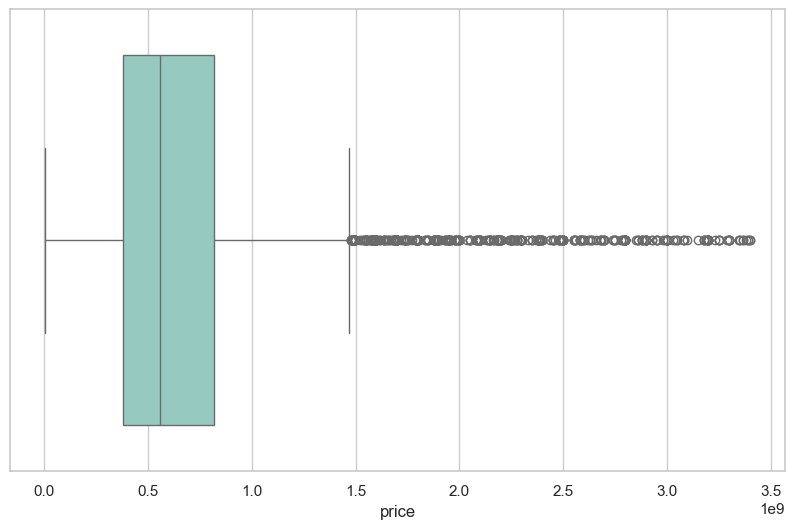

In [17]:
plt.figure(figsize=(10,6))
ax = sns.boxplot(
    x="price",
    data=df,
    palette="Set3"  
)
plt.show()

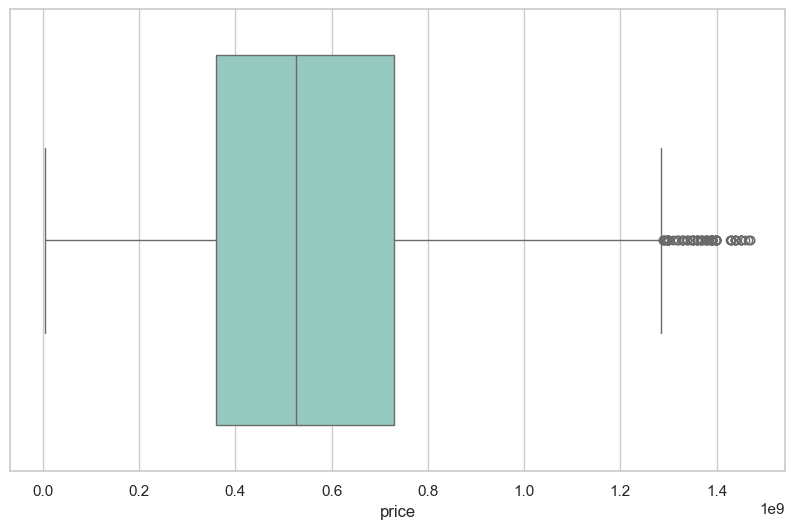

In [18]:
df = remove_outliers_iqr(df, 'price')

plt.figure(figsize=(10,6))
ax = sns.boxplot(
    x="price",
    data=df,
    palette="Set3"  
)
plt.show()

In [19]:
cheapest_10 = df.nsmallest(10, 'price')
cheapest_10


,km,origin,body,fuel,name,price,brand,age
4862,150000.0,Nhập khẩu,Sedan,Xăng,Chính chủ bán Chevrolet Cruze LTZ 2017 màu trắng,5000000.0,Chevrolet,8
4842,65000.0,Nhập khẩu,Sedan,Xăng,BMW 320I GT sx 2017,6900000.0,BMW,8
4569,100000.0,Trong nước,Hatchback,Xăng,Hyundai Grand i10 2019 1 2 BASE 100000 km,7000000.0,Hyundai,6
3529,100000.0,Trong nước,SUV,Điện,VF5 MUA XE VỚI GIÁ 0Đ,12000000.0,VinFast,0
4541,150000.0,Nhập khẩu,Pickup,Dầu,Ford Ranger XLS 2 2L MT,12345678.0,Ford,6
5260,1500.0,Nhập khẩu,Hatchback,Xăng,kẹt vốn làm ăn ra nhanh oto,12500000.0,Kia,11
738,27600.0,Nhập khẩu,SUV,Khác,Ford Everest Ambiente 2 0 AT 4x2 2023,15000000.0,Ford,2
5636,100000.0,Nhập khẩu,Sedan,Xăng,Bán xe đọc kỹ trước khi gọi,19000000.0,Toyota,35
5595,100000.0,Nhập khẩu,Other,Dầu,Mercedes Benz 2004 100000 km,25000000.0,Mercedes Benz,21
5631,10000.0,Nhập khẩu,Other,Xăng,cần bán xe mitsubishi như hình,25000000.0,Mitsubishi,25


6.brand

In [20]:
df["brand"].value_counts()[:10]

brand
Toyota           856
Ford             638
Kia              569
Hyundai          506
Mercedes         372
VinFast          370
Mazda            332
Mitsubishi       302
Honda            223
Mercedes Benz    105
Name: count, dtype: int64

In [21]:
def normalize_brand(x):
    x = str(x).strip()

    mapping = {
        "Mercedes Benz": "Mercedes",
        "Maybach": "Mercedes",

        "Land": "Land Rover",
        "LandRover": "Land Rover",

        "Mini": "Mini",
        "MINI": "Mini",

        "Rolls": "Rolls-Royce",

        "Lynk": "Lynk & Co",
        "Lynk&Co": "Lynk & Co",
    }

    if x in mapping:
        return mapping[x]

    rare_brands = {
        "KenBo","Jeep","Fuso","Bentley","Acura","Luxgen","Ssangyong",
        "Infiniti","Smart","Thaco","Chery","Dodge","Baic","SYM","Asia",
        "Dongfeng","Gaz","Dongben","Daihatsu","Geely","Fiat","Citroen",
        "Hãng khác"
    }

    if x in rare_brands:
        return "Other"

    return x


df["brand"] = df["brand"].apply(normalize_brand)

df["brand"].value_counts()


brand
Toyota         856
Ford           638
Kia            569
Hyundai        506
Mercedes       478
VinFast        370
Mazda          332
Mitsubishi     302
Honda          223
Peugeot         93
Suzuki          89
BMW             86
Chevrolet       74
MG              74
Nissan          69
Lexus           60
Audi            48
Other           39
Porsche         35
Volvo           30
Subaru          20
Daewoo          19
Land Rover      17
Volkswagen      17
Isuzu           15
BYD              7
Mini             5
Lynk & Co        4
Rolls-Royce      4
Jaguar           4
Name: count, dtype: int64

7.age

In [22]:
df["age"].describe()

count      5083.0
mean     5.954161
std      4.782032
min           0.0
25%           3.0
50%           5.0
75%           8.0
max          36.0
Name: age, dtype: Float64

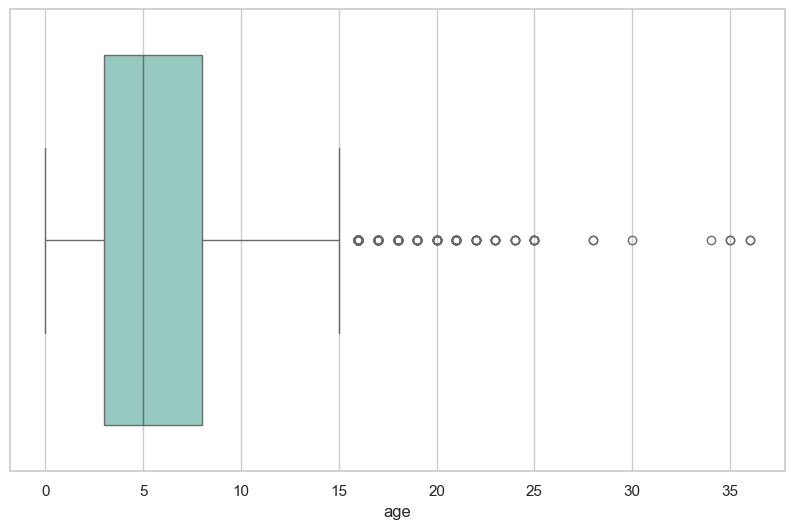

In [23]:
plt.figure(figsize=(10,6))
ax = sns.boxplot(
    x="age",
    data=df,
    palette="Set3"  
)
plt.show()

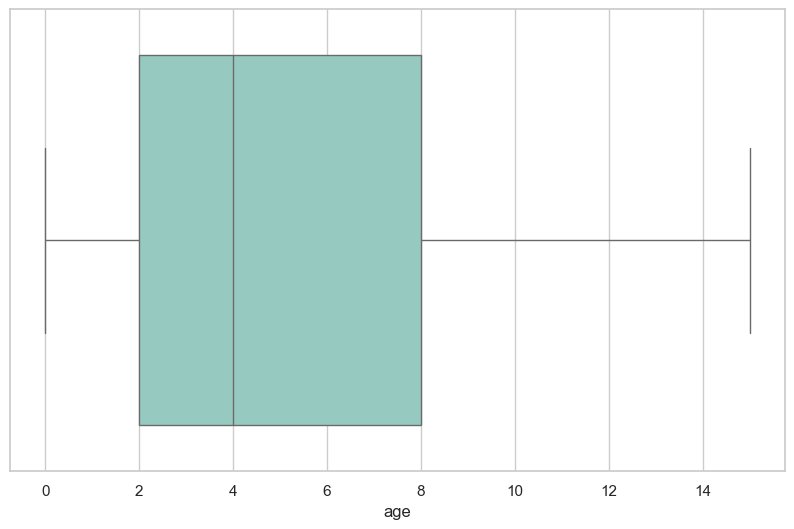

In [24]:
df = remove_outliers_iqr(df, 'age')

plt.figure(figsize=(10,6))
ax = sns.boxplot(
    x="age",
    data=df,
    palette="Set3"  
)
plt.show()

In [25]:
df.drop(columns=["name"], inplace=True)

In [26]:
X = df.drop(columns=["price"])
X.head()

,km,origin,body,fuel,brand,age
0,70000.0,Trong nước,SUV,Khác,Hyundai,4
1,78000.0,Trong nước,SUV,Khác,Hyundai,5
2,130000.0,Nhập khẩu,MPV,Khác,Hyundai,8
3,15000.0,Nhập khẩu,MPV,Khác,Hyundai,8
4,130000.0,Nhập khẩu,MPV,Khác,Hyundai,8


In [27]:
X[X.duplicated(keep=False)]


,km,origin,body,fuel,brand,age
2,130000.0,Nhập khẩu,MPV,Khác,Hyundai,8
4,130000.0,Nhập khẩu,MPV,Khác,Hyundai,8
26,8000.0,Nhập khẩu,SUV,Khác,Hyundai,0
27,8000.0,Nhập khẩu,SUV,Khác,Hyundai,0
40,40000.0,Trong nước,Sedan,Khác,Hyundai,4
...,...,...,...,...,...,...
5384,118000.0,Nhập khẩu,Hatchback,Xăng,Toyota,14
5385,118000.0,Nhập khẩu,Hatchback,Xăng,Toyota,14
5391,83000.0,Nhập khẩu,Convertible,Xăng,Audi,15
5392,83000.0,Nhập khẩu,Convertible,Xăng,Audi,15


In [28]:
df_unique = df.groupby(list(X.columns), as_index=False)["price"].mean()
df_unique

,km,origin,body,fuel,brand,age,price
0,105.0,Nhập khẩu,SUV,Dầu,Toyota,8,627000000.0
1,110.0,Nhập khẩu,MPV,Khác,Kia,15,200000000.0
2,112.0,Nhập khẩu,Hatchback,Xăng,Hyundai,10,165000000.0
3,112.0,Nhập khẩu,Hatchback,Xăng,Kia,13,85000000.0
4,112.0,Nhập khẩu,Hatchback,Xăng,Kia,14,195000000.0
...,...,...,...,...,...,...,...
4121,170000.0,Trong nước,MPV,Xăng,Toyota,10,305000000.0
4122,170000.0,Trong nước,Other,Dầu,Ford,6,398000000.0
4123,170000.0,Trong nước,Other,Xăng,Ford,15,188000000.0
4124,170000.0,Trong nước,Other,Xăng,Toyota,15,235000000.0


In [29]:
df_unique.duplicated().sum()

np.int64(0)

In [30]:
import json


unique_values = {
    'origin': df['origin'].value_counts().index.tolist(),
    'fuel':   df['fuel'].value_counts().index.tolist(),
    'body':   df['body'].value_counts().index.tolist(),
    'brand':  df['brand'].value_counts().index.tolist(),
}

with open('../../model/unique_values.json', 'w', encoding='utf-8') as f:
    json.dump(unique_values, f, ensure_ascii=False, indent=2)

In [31]:
upload_to_bigquery(df_unique, table_id=table_id_done, if_exists="replace" )

✅ Uploaded 4126 rows to khangtestdbt.xecupredict.data_done


* feature engineering

In [32]:
df_unique["km_group"] = pd.cut(
    df_unique["km"],
    bins=[0, 50000, 100000, 150000, 300000, 1000000],
    labels=["very_low", "low", "medium", "high", "very_high"]
)

In [33]:
def age_risk(age):
    if age <= 3: return "new"
    elif age <= 7: return "mid"
    elif age <= 12: return "old"
    else: return "very_old"

df_unique["age_risk"] = df_unique["age"].apply(age_risk)


In [34]:
df_unique["old_car"] = (df_unique["age"] > 10).astype(int)
df_unique["high_km"] = (df_unique["km"] > 100000).astype(int)


In [35]:
df_unique.head()

,km,origin,body,fuel,brand,age,price,km_group,age_risk,old_car,high_km
0,105.0,Nhập khẩu,SUV,Dầu,Toyota,8,627000000.0,very_low,old,0,0
1,110.0,Nhập khẩu,MPV,Khác,Kia,15,200000000.0,very_low,very_old,1,0
2,112.0,Nhập khẩu,Hatchback,Xăng,Hyundai,10,165000000.0,very_low,old,0,0
3,112.0,Nhập khẩu,Hatchback,Xăng,Kia,13,85000000.0,very_low,very_old,1,0
4,112.0,Nhập khẩu,Hatchback,Xăng,Kia,14,195000000.0,very_low,very_old,1,0


* scale

In [36]:
X = df_unique.copy()

In [37]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4126 entries, 0 to 4125
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   km        4126 non-null   float64 
 1   origin    4126 non-null   object  
 2   body      4126 non-null   object  
 3   fuel      4126 non-null   object  
 4   brand     4126 non-null   object  
 5   age       4126 non-null   Int64   
 6   price     4126 non-null   float64 
 7   km_group  4126 non-null   category
 8   age_risk  4126 non-null   object  
 9   old_car   4126 non-null   int64   
 10  high_km   4126 non-null   int64   
dtypes: Int64(1), category(1), float64(2), int64(2), object(5)
memory usage: 330.7+ KB


In [38]:
X_ = X[["price"]]

In [39]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

categorical_cols = [col for col in X.columns 
                    if X[col].dtype == 'object' and col not in X_]
numerical_cols = [col for col in X.columns 
                  if X[col].dtype in ['float64', 'int64', 'Int64'] and col not in X_]

ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_cat = ohe.fit_transform(X[categorical_cols])
cat_feature_names = ohe.get_feature_names_out(categorical_cols)
X_cat_df = pd.DataFrame(X_cat, columns=cat_feature_names, index=X.index)


scaler = StandardScaler()
X_num = scaler.fit_transform(X[numerical_cols])
X_num_df = pd.DataFrame(X_num, columns=numerical_cols, index=X.index)

X_encoded = pd.concat([X_num_df, X_cat_df, X_], axis=1)
X_encoded.shape

(4126, 57)

In [40]:
X_encoded.head()

,km,age,old_car,high_km,origin_Nhập khẩu,origin_Trong nước,body_Convertible,body_Coupe,body_Hatchback,body_MPV,...,brand_Suzuki,brand_Toyota,brand_VinFast,brand_Volkswagen,brand_Volvo,age_risk_mid,age_risk_new,age_risk_old,age_risk_very_old,price
0,-1.739179,0.678972,-0.342416,-0.375973,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,627000000.0
1,-1.739041,2.585084,2.920423,-0.375973,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,200000000.0
2,-1.738986,1.223576,-0.342416,-0.375973,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,165000000.0
3,-1.738986,2.040480,2.920423,-0.375973,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,85000000.0
4,-1.738986,2.312782,2.920423,-0.375973,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,195000000.0


In [41]:
from joblib import dump

dump(ohe, "../../model/onehot_encoder.pkl")
dump(scaler,"../../model/scaler.pkl")

['../../model/scaler.pkl']

In [42]:
upload_to_bigquery(X_encoded, table_id=table_id, if_exists="replace" )

✅ Uploaded 4126 rows to khangtestdbt.xecupredict.data_train_model
